# Marketing G2

In [ ]:
conda install -c conda-forge scikit-surprise

In [130]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import interact 
from sklearn.neighbors import kneighbors_graph
import random as rnd
from scipy.sparse import csr_matrix
from ipywidgets import interact
import os 
import sqlite3 as sql 
import seaborn as sns
from surprise import Dataset
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import SVD, SVDpp, NMF, SlopeOne, CoClustering, KNNBaseline, KNNWithZScore, KNNWithMeans, KNNBasic, BaselineOnly, NormalPredictor

## Import data sets

In [2]:
movies=pd.read_csv(r'C:\Users\PC\Desktop\Analitica 3\Marketing\code\movies_full')
ratings=pd.read_csv(r'C:\Users\PC\Desktop\Analitica 3\Marketing\code\ratings')
users=pd.read_csv(r'C:\Users\PC\Desktop\Analitica 3\Marketing\code\users')

In [3]:
# Seleccionar las columnas que se desean mantener
cols_movies = ['movieId', 'title', 'genres']

# Eliminar las columnas que no se desean mantener
movies1 = movies.drop(columns=[col for col in movies.columns if col not in cols_movies])

In [4]:
#Se cambia el tipo objeto de la columna a formato fecha
ratings['date'] = pd.to_datetime(ratings['date'])

In [5]:
#Crear una nueva base de datos con la unión de las tablas de movies y ratings. 
movie_ratings = pd.merge(ratings,movies1, how="left", right_on="movieId", left_on="movieId")
movie_ratings.head()

,userId,movieId,rating,date,title,genres
0,1,1,4.0,2000-07-30 13:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,2000-07-30 13:20:47,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,2000-07-30 13:37:04,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,2000-07-30 14:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,2000-07-30 13:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [6]:
#Crear base de datos con variables dummies relacionado al género de películas.
genres = movies1.copy()
genres = genres.drop(columns=['movieId', 'title'])
genres['genres'] = genres['genres'].str.split('|')
genres_dummies = pd.get_dummies(pd.DataFrame(genres['genres'].tolist()).stack()).sum(level=0)
genres = pd.concat([genres, genres_dummies], axis=1).drop(columns=['genres'])
genres

C:\Users\PC\AppData\Local\Temp/ipykernel_11432/3998331566.py:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  genres_dummies = pd.get_dummies(pd.DataFrame(genres['genres'].tolist()).stack()).sum(level=0)


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9738,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9740,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
#Concatenar la base de datos movies con la base de datos de los generos de peliculas (dummies), eliminado la columna inicial de generos.
movies2 = pd.concat([movies1, genres], axis=1)
movies2 = movies2.drop(['genres'], axis=1)
movies2.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#Concatenar bases de datos de movies con dummies y ratings.
movie_ratings1 = pd.merge(ratings,movies2, how="left", right_on="movieId", left_on="movieId")
movie_ratings1.head(3)

,userId,movieId,rating,date,title,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2000-07-30 13:45:03,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,2000-07-30 13:20:47,Grumpier Old Men (1995),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,2000-07-30 13:37:04,Heat (1995),0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
#Se crea un nuevo df con pd.melt para invertir las columnas en filas y  conocer la información de los géneros de las películas.
movies3 = pd.melt(movies2, id_vars= ['movieId', 'title'])
movies3.sample(10)

,movieId,title,variable,value
124536,87522,Larry Crowne (2011),IMAX,0
34760,26593,Hell Comes to Frogtown (1988),Animation,0
171356,30822,In Good Company (2004),Thriller,0
46053,70015,Polytechnique (2009),Children,0
97993,703,Boys (1996),Film-Noir,0
185407,351,"Corrina, Corrina (1994)",Western,0
129013,3141,"Two Jakes, The (1990)",Musical,0
90220,3403,Raise the Titanic (1980),Fantasy,0
169380,5256,Stolen Summer (2002),Thriller,0
44652,27722,Last Life in the Universe (Ruang rak noi nid m...,Children,0


In [10]:
#Conococer la cantidad de calificaciones por género de película.
movies3.groupby('variable')[['value']].sum().reset_index()

,variable,value
0,(no genres listed),34.0
1,Action,1828.0
2,Adventure,1263.0
3,Animation,611.0
4,Children,664.0
5,Comedy,3756.0
6,Crime,1199.0
7,Documentary,440.0
8,Drama,4361.0
9,Fantasy,779.0


In [11]:
ratings.head(5)

,userId,movieId,rating,date
0,1,1,4.0,2000-07-30 13:45:03
1,1,3,4.0,2000-07-30 13:20:47
2,1,6,4.0,2000-07-30 13:37:04
3,1,47,5.0,2000-07-30 14:03:35
4,1,50,5.0,2000-07-30 13:48:51


## EDA

In [12]:
n_users = ratings.userId.unique().shape[0]
n_items = ratings.movieId.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

610 users
9724 items


In [13]:
px.histogram(ratings.rating)
#Los usuarios no les tiran tan duro a las peliculas#

In [14]:
ratings.groupby(['rating'])['userId'].count()

rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: userId, dtype: int64

In [15]:
URmatrix = pd.pivot_table(ratings, values='rating', index='movieId', columns='userId').fillna(0)
URmatrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
rate = URmatrix.values
sparsity = float(len(rate.nonzero()[0]))
sparsity /= (rate.shape[0] * rate.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))#!!!!!!!!!!!!! Mucha Sparsity; Muchos 0s

Sparsity: 1.70%


In [17]:
#saber cuantas calificaciones tiene cada pelicula y cuantas veces el usuario ha calificado.
usuariovotos = ratings.groupby('movieId')['rating'].agg('count')
peliculavotos = ratings.groupby('userId')['rating'].agg('count')

#¿Cúal es el maximo y mínimo de calificaciones de una película?


print('¿Cúal es el maximo y mínimo de calificaciones de un usuario?')
print(usuariovotos.max())
print(usuariovotos.min())

print('¿Cúal es el maximo y minimo de calificacionesde una pelicula?')
print(peliculavotos.max())
print(peliculavotos.min())

¿Cúal es el maximo y mínimo de calificaciones de un usuario?
329
1
¿Cúal es el maximo y minimo de calificacionesde una pelicula?
2698
20


In [18]:
#Filtra por cantidad de votos y recomendaciones, para reducir la sparcity y tener mas fiabilidad
URmatrix = URmatrix.loc[usuariovotos[usuariovotos > 10].index,:]
URmatrix=URmatrix.loc[:,peliculavotos[peliculavotos > 100].index]
URmatrix

userId,1,4,6,7,10,15,17,18,19,20,...,599,600,601,602,603,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,2.5,4.5,3.5,4.0,0.0,...,3.0,2.5,4.0,0.0,4.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,...,2.5,4.0,0.0,4.0,0.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,4.5,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.5,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
rate = URmatrix.values
sparsity = float(len(rate.nonzero()[0]))
sparsity /= (rate.shape[0] * rate.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity)) #MEJORAAAAA!!!!!!

Sparsity: 12.38%


In [20]:
# Con el fin de comprender mejor los datos, se planterán algunas preguntasa acerca de los mismos
# ¿Cuáles son las películas con mejor calificación?

base = movie_ratings.groupby(['title'])[['rating']].count().sort_values('rating', ascending = False).reset_index().head(10)

# Gráfica
fig = px.bar(base, x = 'title', y='rating',
             title= '<b>Películas mejor calificadas<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# Agrear etiquetas a las barras
fig.update_layout(
    xaxis_title = 'Películas',
    yaxis_title = 'Calificación',
    template = 'simple_white',
    title_x = 0.5)

In [21]:
# ¿Cuáles son las películas con menor calificación?
base = movie_ratings.groupby(['title'])[['rating']].count().sort_values('rating', ascending = True).reset_index().head(10)

# Gráfica
fig = px.bar(base, x = 'title', y='rating',
             title= '<b>Películas con menor calificación<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# Agrear etiquetas a las barras
fig.update_layout(
    xaxis_title = 'Películas',
    yaxis_title = 'Calificación',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [22]:
# ¿Cúales son los 5 géneros más vistos?
base = movies3.groupby(['variable'])[['value']].sum().sort_values('value', ascending = False).reset_index().head(5)

# Gráfica
fig = px.pie(base, values = 'value', names ='variable',
             title= '<b>Top 5 géneros de películas<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# Agrear etiquetas a las porciones
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [23]:
# ¿Cúales son los 5 géneros menos vistos?
base = movies3.groupby(['variable'])[['value']].sum().sort_values('value', ascending = True).reset_index().head(5)

# Gráfica
fig = px.pie(base, values = 'value', names ='variable',
             title= '<b> Top 5 películas que menos se ven<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# # Agrear etiquetas a las porciones
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5)

fig.show()

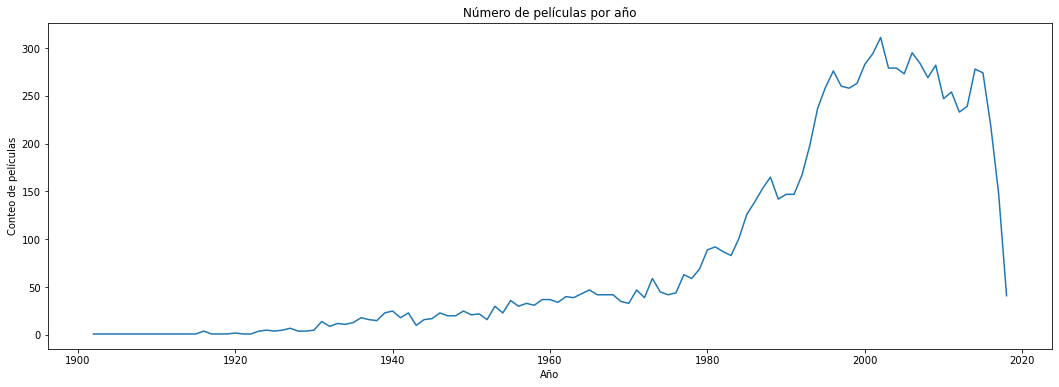

In [24]:
#¿Cúal ha sido el comportamiento del número de películas por año a medida que pasa el tiempo? y ¿cúal es el año con mayor número de películas?
#Para responder estas preguntas, se debe extraer el año de la columna 'title' de la tabla de movies.
movies['year'] = movies['title'].str.extract('\((\d{4})\)',expand = False)
movies = movies.dropna(axis=0)
movies['year'] = movies['year'].astype('int64')
movies['title'] = movies['title'].str.extract('(.*?)\s*\(', expand=False)
#Gráfica.
movie_year = pd.DataFrame(movies['title'].groupby(movies['year']).count())
movie_year.reset_index(inplace=True)
movie_year.plot(x='year', y='title', legend=False, xlabel="Año", ylabel="Conteo de películas", title= 'Número de películas por año', figsize=(18, 6));

In [25]:
#¿Cúal ha sido el comportamiento de las calificaciones por parte de los usuarios por año, mes, día del mes y día de la semana?
movie_ratings['Year'] = movie_ratings['date'].dt.year 
movie_ratings['Month'] = movie_ratings['date'].dt.month
movie_ratings['Day'] = movie_ratings['date'].dt.day 
movie_ratings['Dayweek'] = movie_ratings['date'].dt.day_name()

base = movie_ratings.groupby(['Year'])[['rating']].count().sort_values('rating', ascending = False).reset_index()

# Gráfica
fig = px.bar(base, x = 'Year', y='rating',
             title= '<b>Calificaciones por año<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# Agrear etiquetas a las barras
fig.update_layout(
    xaxis_title = 'Año',
    yaxis_title = 'Rating',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

# Recomendatios Systems

## Popularity Based

In [26]:
# Train-Test Split
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.4, random_state=42)
print(ratings_train.shape)
print(ratings_test.shape)

(60501, 4)
(40335, 4)


### General

In [131]:
def popularity(num):
    train_data_grouped=ratings.groupby(['movieId'])['userId'].count().reset_index()
    train_data_grouped.rename(columns={'userId':'score'},inplace=True)
    train_data_sort=train_data_grouped.sort_values(['score','movieId'],ascending=[0,1])
    train_data_sort['Rank']=train_data_sort['score'].rank(ascending=0,method='first')
    popularity_recommendations=train_data_sort.head(num)
    pop_rec_general=pd.merge(popularity_recommendations,movies[['movieId','title']],on='movieId', how='left')
    return pop_rec_general

Como el sistema de recomendacion basado en popularidad es parcialmente inmutable, solo se obtiene un resultado y no un modelo predictivo, como tal.

In [133]:
popularity(2)

,movieId,score,Rank,title
0,356,329,1.0,Forrest Gump (1994)
1,318,317,2.0,"Shawshank Redemption, The (1994)"


### Popular movies per year

In [87]:
def popularity_year(year):
    train_data_grouped=ratings.groupby(['movieId'])['userId'].count().reset_index()
    train_data_grouped=pd.merge(train_data_grouped,movies[['movieId','year']],on='movieId', how='left')
    train_data_grouped.rename(columns={'userId':'score'},inplace=True)
    train_data_sort=train_data_grouped.sort_values(['score','movieId'],ascending=[0,1])
    data_sort_year=train_data_sort[train_data_sort['year']==year].head(10)
    data_sort_year['Rank']=data_sort_year['score'].rank(ascending=0,method='first')
    pop_rec_sys_final=pd.merge(data_sort_year,movies[['movieId','title']],on='movieId', how='left')
    pop_rec_sys_final
    return pop_rec_sys_final

In [88]:
popularity_year(1999)

,movieId,score,year,Rank,title
0,2571,278,1999.0,1.0,"Matrix, The"
1,2959,218,1999.0,2.0,Fight Club
2,2858,204,1999.0,3.0,American Beauty
3,2762,179,1999.0,4.0,"Sixth Sense, The"
4,2628,140,1999.0,5.0,Star Wars: Episode I - The Phantom Menace
5,2683,121,1999.0,6.0,Austin Powers: The Spy Who Shagged Me
6,3147,111,1999.0,7.0,"Green Mile, The"
7,2706,103,1999.0,8.0,American Pie
8,2997,99,1999.0,9.0,Being John Malkovich
9,3114,97,1999.0,10.0,Toy Story 2


### Popularity per Genre

In [112]:
def popularity_genre(genre):
    train_data_grouped=ratings.groupby(['movieId'])['userId'].count().reset_index()
    train_data_grouped=pd.merge(train_data_grouped,movies[['movieId','genres']],on='movieId', how='left')
    train_data_grouped.rename(columns={'userId':'score'},inplace=True)
    train_data_sort=train_data_grouped.sort_values(['score','movieId'],ascending=[0,1])
    train_data_sort['genres']=train_data_sort['genres'].apply(lambda x: str(x))
    train_data_sort['contains_genre']=train_data_sort['genres'].apply(lambda x: genre in x)
    train_data_sort
    data_sort_genre=train_data_sort[train_data_sort['contains_genre']== True].head(10)
    data_sort_genre['Rank']=data_sort_genre['score'].rank(ascending=0,method='first')
    pop_rec_sys_final=pd.merge(data_sort_genre,movies[['movieId','title']],on='movieId', how='left')
    return pop_rec_sys_final

In [114]:
popularity_genre('Comedy')

,movieId,score,genres,contains_genre,Rank,title
0,356,329,Comedy|Drama|Romance|War,True,1.0,Forrest Gump
1,296,307,Comedy|Crime|Drama|Thriller,True,2.0,Pulp Fiction
2,1,215,Adventure|Animation|Children|Comedy|Fantasy,True,3.0,Toy Story
3,588,183,Adventure|Animation|Children|Comedy|Musical,True,4.0,Aladdin
4,608,181,Comedy|Crime|Drama|Thriller,True,5.0,Fargo
5,380,178,Action|Adventure|Comedy|Romance|Thriller,True,6.0,True Lies
6,1270,171,Adventure|Comedy|Sci-Fi,True,7.0,Back to the Future
7,4306,170,Adventure|Animation|Children|Comedy|Fantasy|Ro...,True,8.0,Shrek
8,1580,165,Action|Comedy|Sci-Fi,True,9.0,Men in Black
9,344,161,Comedy,True,10.0,Ace Ventura: Pet Detective


Shotout to Rogish Ghosh to help us with the popularity based recommendation system.

## Content Based

### KNN

In [31]:
# Se utilizo KNN como algoritmo de aprendizaje no supervisado y su competitividad e indicadores

In [32]:
valUR = csr_matrix(URmatrix.values)
URmatrix.reset_index(inplace=True)

In [33]:
#Se usa con metrica de coseno porque permite calcular la distancia y computacionalmente es más rapida.
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(valUR)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [34]:
#Con el modeloe ntrenado, podemos hacer una funcion para recomendar 4 peliculas, basadas en una ingresada
def get_movie_recommendation(Movie_id = list(movies['title'])):
    n_movies_to_reccomend = 10
    
    if len(Movie_id):
        Movie_id=movies[movies['title']==(Movie_id)]        
        movie_idx= Movie_id.iloc[0]['movieId']
        
        distances , indices = knn.kneighbors(valUR[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),\
                               key=lambda x: x[1])[:0:-1]
        
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = URmatrix.iloc[val[0]]['movieId']
            idx =movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df.sort_values(by=['Distance'])
    
    else:
        
        return "No movies found. Please check your input"

In [35]:
print(interact(get_movie_recommendation))

interactive(children=(Dropdown(description='Movie_id', options=('Toy Story', 'Jumanji', 'Grumpier Old Men', 'W…

<function get_movie_recommendation at 0x00000207A9D36CA0>


## Filtros Colaborativos

In [127]:
os.getcwd()
os.chdir(r'C:\Users\PC\Desktop\Analitica 3\Marketing\code')

conn=sql.connect('db_movies')
cur=conn.cursor()

cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

ratings=pd.read_sql("""select * FROM  ratings""", conn)
movies=pd.read_sql("""select * FROM  movies""", conn)

reader = Reader(rating_scale= (1,5))
data_sp = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)

modelos =  [SVD(), NMF(), BaselineOnly(), SlopeOne(), KNNBasic(),KNNWithMeans(),KNNWithZScore(),KNNBaseline(),CoClustering()]
resultados={}

for model in modelos:
 
   CV_scores = cross_validate(model, data_sp, measures=["MAE","RMSE"], cv=5, n_jobs=-1)  
   result = pd.DataFrame.from_dict(CV_scores).mean(axis=0).\
             rename({'test_mae':'MAE', 'test_rmse': 'RMSE'})
   resultados[str(model).split("algorithms.")[1].split("object ")[0]] = result


performance_df = pd.DataFrame.from_dict(resultados).T
performance_df.sort_values(by='RMSE')


bsl_options = {'bsl_options':{'método': ['als'], \
               'n_epochs': [5], \
               'reg_u': [12], \
               'reg_i': [5], \
               'user_based':['False'] \
               } 
              }


gridsearchBaselineOnly = GridSearchCV(BaselineOnly,bsl_options, measures=['rmse'], \
                                      cv=2, n_jobs=2)

gridsearchBaselineOnly.fit(data_sp)


best_params=gridsearchBaselineOnly.best_params["rmse"]
best_score=gridsearchBaselineOnly.best_score["rmse"]
gs_model=gridsearchBaselineOnly.best_estimator['rmse']


trainset = data_sp.build_full_trainset()
model=gs_model.fit(trainset) 
predset = trainset.build_anti_testset() 
predictions = model.test(predset)
predictions_df=pd.DataFrame(predictions)
predictions_df['r_ui'].unique() 
predictions_df.sort_values(by='est',ascending=False)


def recomendaciones(user_id,n_recomend=10):
    
    predictions_userID = predictions_df[predictions_df['uid'] == user_id].\
                    sort_values(by="est", ascending = False).head(n_recomend)

    recomendados = predictions_userID[['iid','est']]
    recomendados.to_sql('reco',conn,if_exists="replace")
    
    recomendados=pd.read_sql('''select a.*, m.title
                             from reco a left join movies m
                             on a.iid=m.movieId ''', conn)

    return(recomendados)


 
us1=recomendaciones(user_id=1,n_recomend=20)

[('ratings',), ('movies',)]
Estimating biases using als...


In [129]:
recomendaciones(7,3)

,index,iid,est,title
0,57676,318,4.047456,"Shawshank Redemption, The (1994)"
1,59713,1204,3.986840,Lawrence of Arabia (1962)
2,58713,177593,3.949381,"Three Billboards Outside Ebbing, Missouri (2017)"


# Despliegue

In [ ]:
n=int(input('Ingrese el numero de recomendaciones que desea:'))
u_id=int(input('Ingrese su user ID:'))
y=int(input('Ingrese el año del que quiere recibir recomendaciones:'))
g=input('Ingrese su genero favorito:')
pop=popularity(n)
pop_y=popularity_year(y)
pop_g=popularity_genre(g)
fc=recomendaciones(u_id,n)
with pd.ExcelWriter('Recomendaciones.xlsx') as writer:  
    pop.to_excel(writer, sheet_name='GenPopularity')
    pop_y.to_excel(writer, sheet_name='YearPopularity')
    pop_g.to_excel(writer, sheet_name='GenrePopularity')
    fc.to_excel(writer, sheet_name='CollaborativeFilter')